In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra

import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
import seaborn as sns

# Any results you write to the current directory are saved as output.

sample_submission.csv
test
test.csv
train
train.csv



In [2]:
df_train = pd.read_csv("../input/train.csv",names=['id','spacegroup','numatoms','peral','perga','perin','a','b','c','alpha','beta','gamma','E0','Eg'],skiprows=1)
df_topredict = pd.read_csv("../input/test.csv",names=['id','spacegroup','numatoms','peral','perga','perin','a','b','c','alpha','beta','gamma'],skiprows=1)

Lets go ahead and see what the data to train on and the data to predict on looks like

In [3]:
df_train.head()

,id,spacegroup,numatoms,peral,perga,perin,a,b,c,alpha,beta,gamma,E0,Eg
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


In [4]:

df_topredict.head()

,id,spacegroup,numatoms,peral,perga,perin,a,b,c,alpha,beta,gamma
0,1,33,80.0,0.1875,0.4688,0.3438,10.5381,9.0141,9.6361,89.9997,90.0003,90.0006
1,2,33,80.0,0.7500,0.2500,0.0000,9.8938,8.5014,9.1298,90.0038,90.0023,90.0015
2,3,167,30.0,0.6667,0.1667,0.1667,4.9811,4.9808,13.4799,89.9900,90.0109,120.0014
3,4,12,80.0,0.5625,0.4375,0.0000,24.3370,6.0091,5.7620,89.9995,103.8581,90.0002
4,5,12,80.0,0.1875,0.5000,0.3125,24.6443,6.2906,6.1589,90.0000,104.5929,90.0001


In [5]:
df_cpy = df_train.copy()
df_topredictcpy = df_topredict.copy()


In [6]:
df_cpy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 14 columns):
id            2400 non-null int64
spacegroup    2400 non-null int64
numatoms      2400 non-null float64
peral         2400 non-null float64
perga         2400 non-null float64
perin         2400 non-null float64
a             2400 non-null float64
b             2400 non-null float64
c             2400 non-null float64
alpha         2400 non-null float64
beta          2400 non-null float64
gamma         2400 non-null float64
E0            2400 non-null float64
Eg            2400 non-null float64
dtypes: float64(12), int64(2)
memory usage: 262.6 KB


In [7]:
df_cpy.isnull().sum()

id            0
spacegroup    0
numatoms      0
peral         0
perga         0
perin         0
a             0
b             0
c             0
alpha         0
beta          0
gamma         0
E0            0
Eg            0
dtype: int64

So we have no null values in the dataset.Here i am rounding of the angles. It shouldn't matter much as far the prediction algorithm goes. The reason for the rounding of the angles is that crystal structures usually have well defined angles (90, 90, 90 for cubic; 90,90,120 for hexagonal and so on).

So, lets go ahead and see how the values the lattice angles take.

Text(0.5,0,'gamma')

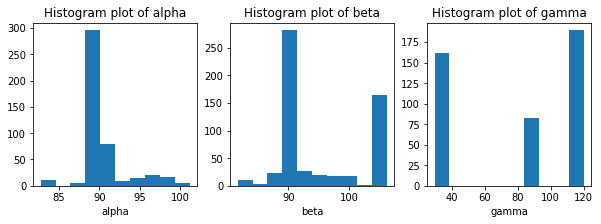

In [8]:
f,ax = plt.subplots(1,3,figsize=(10,3))
ax[0].hist(df_cpy['alpha'].unique())
ax[0].set_title("Histogram plot of alpha")
ax[0].set_xlabel("alpha")
ax[1].hist(df_cpy['beta'].unique())
ax[1].set_title("Histogram plot of beta")
ax[1].set_xlabel("beta")
ax[2].hist(df_cpy['gamma'].unique())
ax[2].set_title("Histogram plot of gamma")
ax[2].set_xlabel("gamma")

In [9]:
df_cpy['alpha'] = np.round(df_cpy['alpha'])
df_cpy['beta'] = np.round(df_cpy['beta'])
df_cpy['gamma'] = np.round(df_cpy['gamma'])
df_topredictcpy['alpha'] = np.round(df_topredictcpy['alpha'])
df_topredictcpy['beta'] = np.round(df_topredictcpy['beta'])
df_topredictcpy['gamma'] = np.round(df_topredictcpy['gamma'])

So we se that the lattice angles alpha and beta always take values near 90 with some variation ~10 degrees, whereas the lattice angle gamma takes on either 90 or 120 or 30 degrees. We will look into more analysis of the lattice angles/ vectors with respect to individual spacegroups a bit later

In [10]:
df_cpy.columns

Index(['id', 'spacegroup', 'numatoms', 'peral', 'perga', 'perin', 'a', 'b',
       'c', 'alpha', 'beta', 'gamma', 'E0', 'Eg'],
      dtype='object')

In [11]:
cols = df_cpy[['peral','perga','perin','a','b','c','alpha','beta','gamma','E0','Eg']]

**Plotting the features with respect to other features**

Since we have 9 features (lattice vectors, lattice angles, composition) and the formation enthalpy and band gap, the plots of the features look quite cluttered. For the time being let us just look at a bird's eye view of the these features and then focus more on the features which show more correlation later

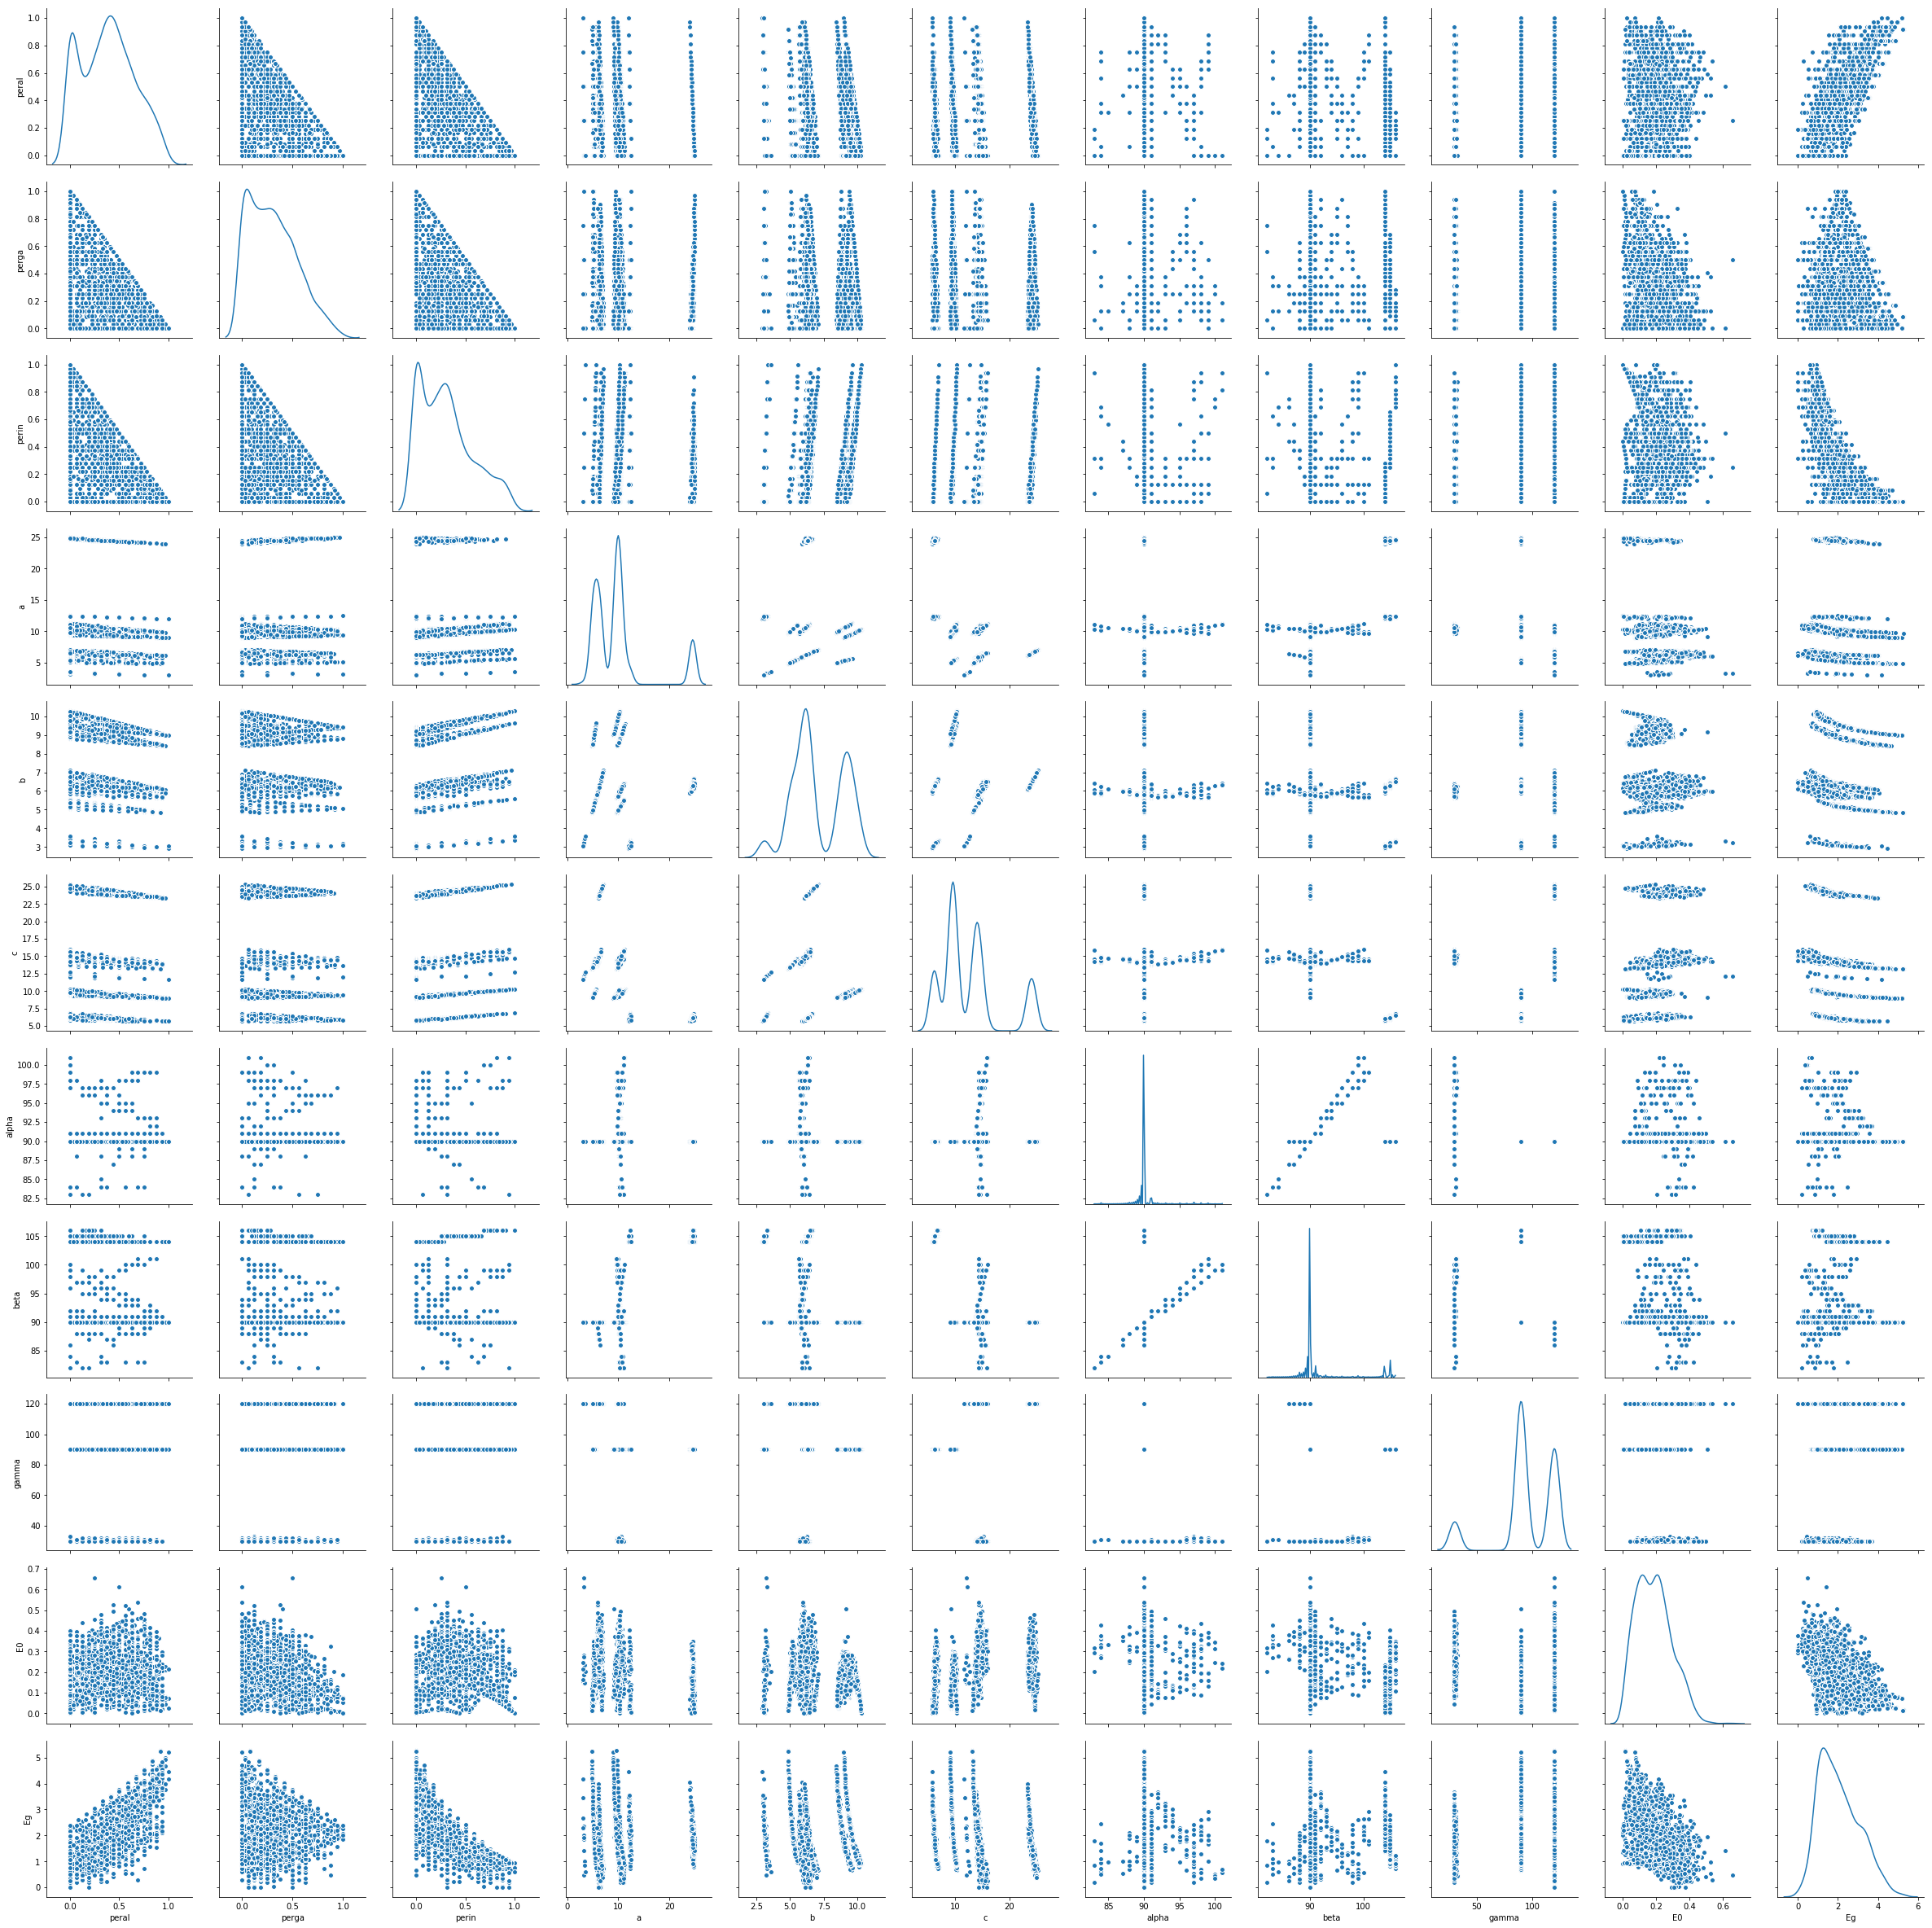

In [12]:

sns.pairplot(cols, diag_kind="kde",size=3,aspect=1)


Text(0,0.5,'c')

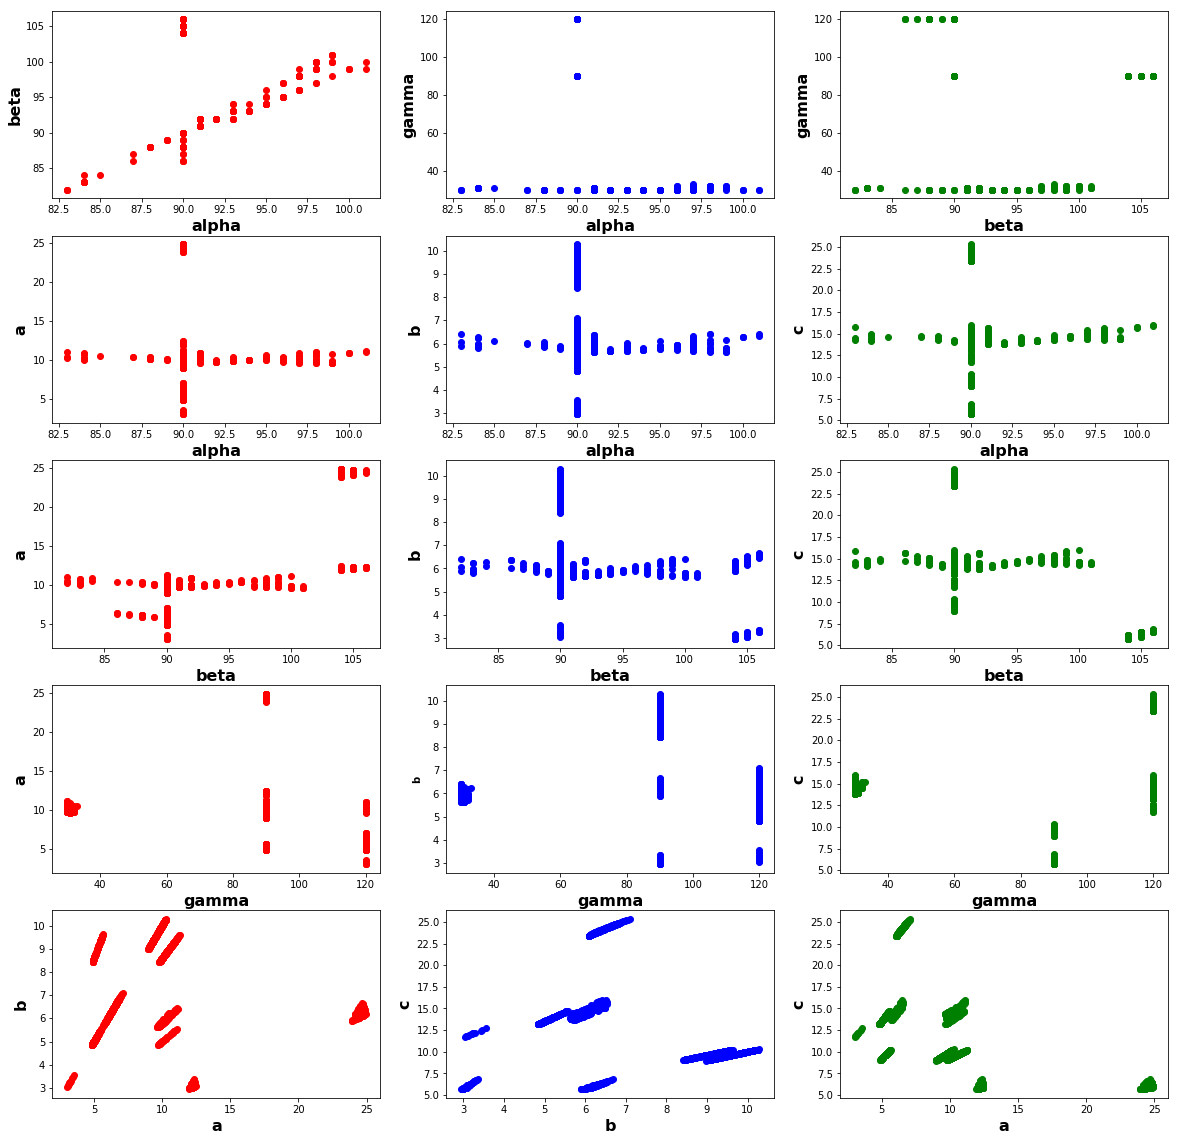

In [13]:
f,ax = plt.subplots(5,3,figsize=(20,20))
ax[0,0].plot(df_cpy['alpha'],df_cpy['beta'],'ro')
ax[0,0].set_xlabel("alpha",fontweight='bold',fontsize=16)
ax[0,0].set_ylabel("beta",fontweight='bold',fontsize=16)
ax[0,1].plot(df_cpy['alpha'],df_cpy['gamma'],'bo')
ax[0,1].set_xlabel("alpha",fontweight='bold',fontsize=16)
ax[0,1].set_ylabel("gamma",fontweight='bold',fontsize=16)
ax[0,2].plot(df_cpy['beta'],df_cpy['gamma'],'go')
ax[0,2].set_xlabel("beta",fontweight='bold',fontsize=16)
ax[0,2].set_ylabel("gamma",fontweight='bold',fontsize=16)
ax[1,0].plot(df_cpy['alpha'],df_cpy['a'],'ro')
ax[1,0].set_xlabel("alpha",fontweight='bold',fontsize=16)
ax[1,0].set_ylabel("a",fontweight='bold',fontsize=16)
ax[1,1].plot(df_cpy['alpha'],df_cpy['b'],'bo')
ax[1,1].set_xlabel("alpha",fontweight='bold',fontsize=16)
ax[1,1].set_ylabel("b",fontweight='bold',fontsize=16)
ax[1,2].plot(df_cpy['alpha'],df_cpy['c'],'go')
ax[1,2].set_xlabel("alpha",fontweight='bold',fontsize=16)
ax[1,2].set_ylabel("c",fontweight='bold',fontsize=16)
ax[2,0].plot(df_cpy['beta'],df_cpy['a'],'ro')
ax[2,0].set_xlabel("beta",fontweight='bold',fontsize=16)
ax[2,0].set_ylabel("a",fontweight='bold',fontsize=16)
ax[2,1].plot(df_cpy['beta'],df_cpy['b'],'bo')
ax[2,1].set_xlabel("beta",fontweight='bold',fontsize=16)
ax[2,1].set_ylabel("b",fontweight='bold',fontsize=16)
ax[2,2].plot(df_cpy['beta'],df_cpy['c'],'go')
ax[2,2].set_xlabel("beta",fontweight='bold',fontsize=16)
ax[2,2].set_ylabel("c",fontweight='bold',fontsize=16)
ax[3,0].plot(df_cpy['gamma'],df_cpy['a'],'ro')
ax[3,0].set_xlabel("gamma",fontweight='bold',fontsize=16)
ax[3,0].set_ylabel("a",fontweight='bold',fontsize=16)
ax[3,1].plot(df_cpy['gamma'],df_cpy['b'],'bo')
ax[3,1].set_xlabel("gamma",fontweight='bold',fontsize=16)
ax[3,1].set_ylabel("b",fontweight='bold')
ax[3,2].plot(df_cpy['gamma'],df_cpy['c'],'go')
ax[3,2].set_xlabel("gamma",fontweight='bold',fontsize=16)
ax[3,2].set_ylabel("c",fontweight='bold',fontsize=16)
ax[4,0].plot(df_cpy['a'],df_cpy['b'],'ro')
ax[4,0].set_xlabel("a",fontweight='bold',fontsize=16)
ax[4,0].set_ylabel("b",fontweight='bold',fontsize=16)
ax[4,1].plot(df_cpy['b'],df_cpy['c'],'bo')
ax[4,1].set_xlabel("b",fontweight='bold',fontsize=16)
ax[4,1].set_ylabel("c",fontweight='bold',fontsize=16)
ax[4,2].plot(df_cpy['a'],df_cpy['c'],'go')
ax[4,2].set_xlabel("a",fontweight='bold',fontsize=16)
ax[4,2].set_ylabel("c",fontweight='bold',fontsize=16)

So we see that there is a strong positive correlation  between alpha and beta, 

**Correlation Matrix**

The correlation matrix is similar to the pair plotting of the features we saw above but is more quantitative and helps us understand more which the plots dont give away readily. Now lets go ahead and see how the features are correlated and see if they have any similarities.

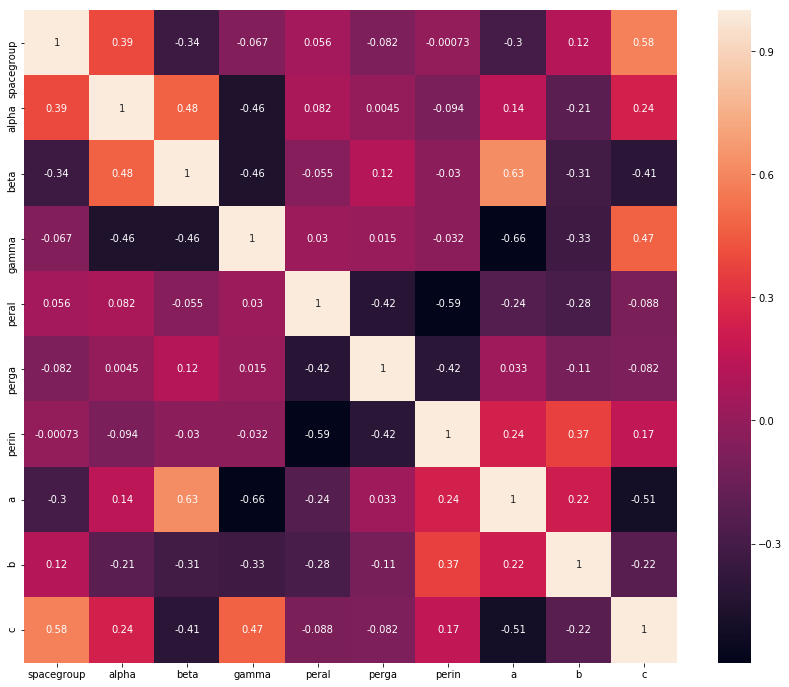

In [14]:
cols = df_cpy[['spacegroup','alpha','beta','gamma','peral','perga','perin','a','b','c']]
corrmat = cols.corr(method='spearman')
plt.subplots(figsize=(15,12))
sns.heatmap(corrmat, vmax=1., square=True,annot=True,robust=True)

I focus only on the pairs whcih yield high values of correlation (ie >0.3) because a lot of the cases below this value might purley be an artifact of the dataset. Let us start with the lattice angles. 

Alpha has a strong positive correlation with beta, a strong negative correlation with gamma.

Beta has a strong positive correlation with alpha, a strong negative correlation with gamma, a very strong positive correlation with a, and strong negative correlations with b,c.

Gamma has strong negative correlations with alpha, beta, b, strong positive correlation with c and a very strong negative correlation with a.

peral (aluminium composition) has strong negative correlations with per in (indium composition) and per ga (gallium composition). 

perga (gallium composition) has strong negative correlations with per al  and per in. 

perin (indium composition) has strong negative correlations with per al  and per ga and a strong positive b 


.  In principle, that is not the case expected in crystal systems as the lattice angles are fully independent to vary with respect to each other. So this correlation might strongly be influenced by the particular dataset we are looking at.  Lets plot these angles wrt to each other and see how they vary.


Now, lets look at the different spacegroups and see what spacegroups the structures are taken from. 

In [15]:
sorted(df_cpy['spacegroup'].unique())


[12, 33, 167, 194, 206, 227]

In [16]:
sorted(df_topredictcpy['spacegroup'].unique())

[12, 33, 167, 194, 206, 227]

Text(0,0.5,'% of sample set')

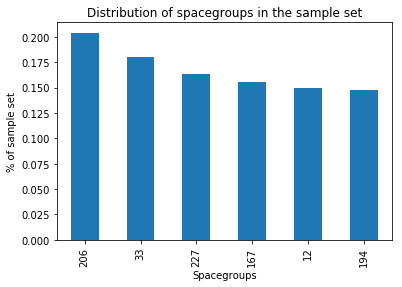

In [29]:
df_cpy['spacegroup'].value_counts(normalize=True).plot.bar()
plt.title("Distribution of spacegroups in the sample set")
plt.xlabel("Spacegroups")
plt.ylabel("% of sample set")

Text(0,0.5,'% of sample set')

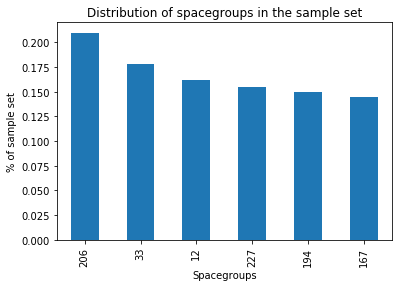

In [30]:
df_topredictcpy['spacegroup'].value_counts(normalize=True).plot.bar()
plt.title("Distribution of spacegroups in the sample set")
plt.xlabel("Spacegroups")
plt.ylabel("% of sample set")

So, we see that the samples used for training and samples to be predicted are from the same spacegroups. The distribution of the samples in the different spacegroups in both the training set and the set to be predicted takes a similar distribution. So, we know that the sample taken for training is a good statistical sample set.  Now lets look how the inidividual compositions are stacked up wrt to the different spacegroups. 


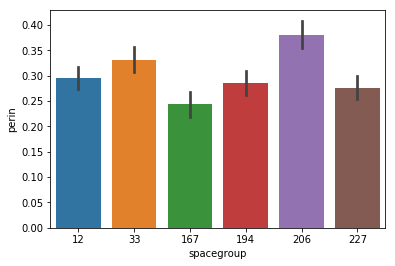

In [31]:
sns.barplot(df_cpy['spacegroup'],df_cpy['perin'])

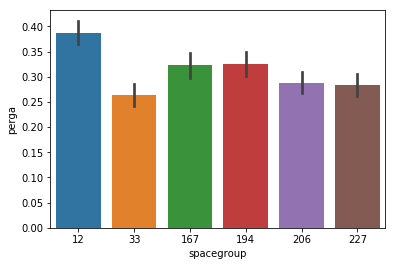

In [32]:
sns.barplot(df_cpy['spacegroup'],df_cpy['perga'])

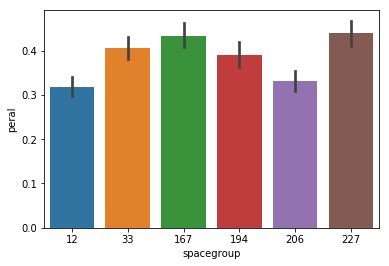

In [33]:
sns.barplot(df_cpy['spacegroup'],df_cpy['peral'])

So we see that the compositions of aluminium, gallium and indium pretty much have similar ranges of compositons in each spacegroup. 

Now let us look at how bandgaps and formation enthalpies vary with elemental compositions

Text(0.5,0,'% of Aluminium')

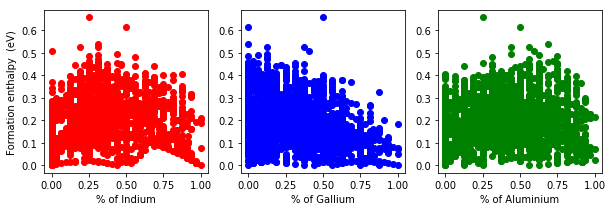

In [34]:
f,ax = plt.subplots(1,3,figsize=(10,3))
ax[0].plot(df_cpy['perin'],df_cpy['E0'],'ro')
ax[0].set_xlabel("% of Indium")
ax[0].set_ylabel("Formation enthalpy  (eV)")
ax[1].plot(df_cpy['perga'],df_cpy['E0'],'bo')
ax[1].set_xlabel("% of Gallium")
ax[2].plot(df_cpy['peral'],df_cpy['E0'],'go')
ax[2].set_xlabel("% of Aluminium")

We see that aluminium and indium compositions dont matter too much for the formation enthalpy, but there is a systematic decrease in the formation enthalpy with increasing gallium composition

Text(0.5,0,'% of Aluminium')

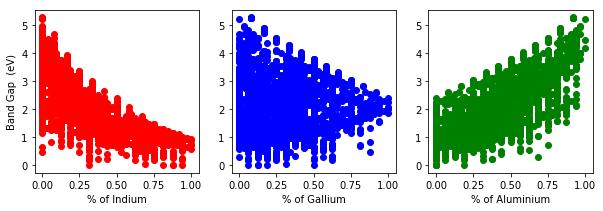

In [35]:
f,ax = plt.subplots(1,3,figsize=(10,3))
ax[0].plot(df_cpy['perin'],df_cpy['Eg'],'ro')
ax[0].set_xlabel("% of Indium")
ax[0].set_ylabel("Band Gap  (eV)")
ax[1].plot(df_cpy['perga'],df_cpy['Eg'],'bo')
ax[1].set_xlabel("% of Gallium")
ax[2].plot(df_cpy['peral'],df_cpy['Eg'],'go')
ax[2].set_xlabel("% of Aluminium")

Unlike formation enthalpies, we see some clear trends in band gap as a function of compositions. In particular, increasing aluminium and decreasing indium leads to increasing band gap values. Increase in the gallium composition however attains a range of values (depending on the aluminium and indium compositions) and tapers out to ~ 2 eV for 100 % Gallium. So ideally for high band gap values, we would want low compositions of indium, medium compositions of gallium and high compositions of Aluminium. However, high compositions of gallium lead to low formation enthalpy values. Thus we would want compounds with high compositions of gallium and aluminium


Now,let's look at the geometric characteristics of each spacegroup based on the dataset we have

In [36]:
crystal_vectors = ['a','b','c','alpha','beta','gamma']

In [37]:
crystal_vectors_withbandandenergy = ['a','b','c','alpha','beta','gamma','Eg','E0','perin','peral','perga']

**Space group 12**

This is a monoclinic structure with the lattice vectors not being equal, two lattice angles are 90 and the other lattice angle can take any value

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d2dea41d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6d2d98b0f0>]], dtype=object)

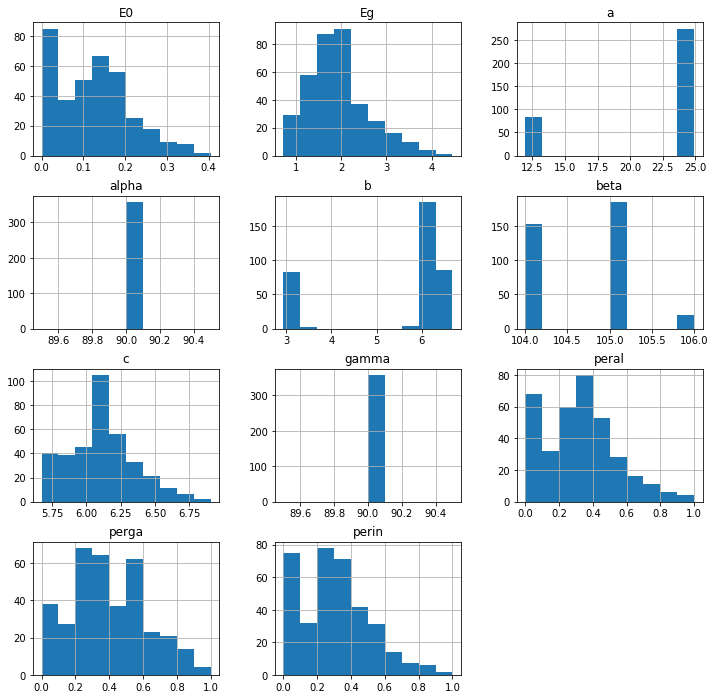

In [38]:
#plt.subplots(figsize=(15,12))
df_cpy[df_cpy['spacegroup']==12].hist(figsize=(12,12),column=crystal_vectors_withbandandenergy)


In [41]:
df_cpy[df_cpy['spacegroup']==12]['alpha'].unique()

array([ 90.])

So in space group 12, we see that gamma and alpha takes only one value (90), while beta takes (104,105 and 106) (ie. not 90). a,b,c are not equal, while E0 takes values from 0 - 0.4 while Eg takes on values from 0-4 centered around 2 eV. The compositions of aluminium, gallium and indium take compositions from 0-1. So there is no particular preferece for the compositions to be in particular spacegroups

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d2d4a94e0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6d2d0732e8>]], dtype=object)

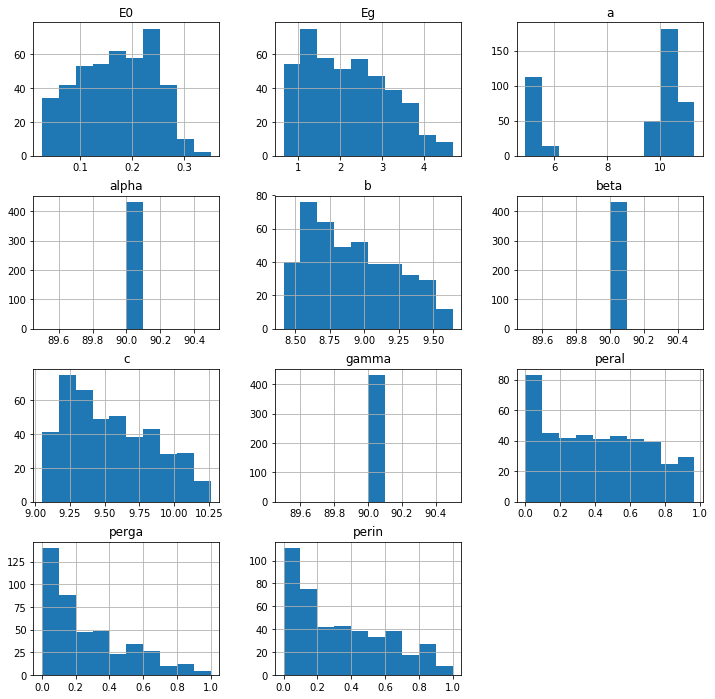

In [42]:
#plt.subplots(figsize=(15,12))
df_cpy[df_cpy['spacegroup']==33].hist(figsize=(12,12),column=crystal_vectors_withbandandenergy)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d2cd845f8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6d2cb3de10>]], dtype=object)

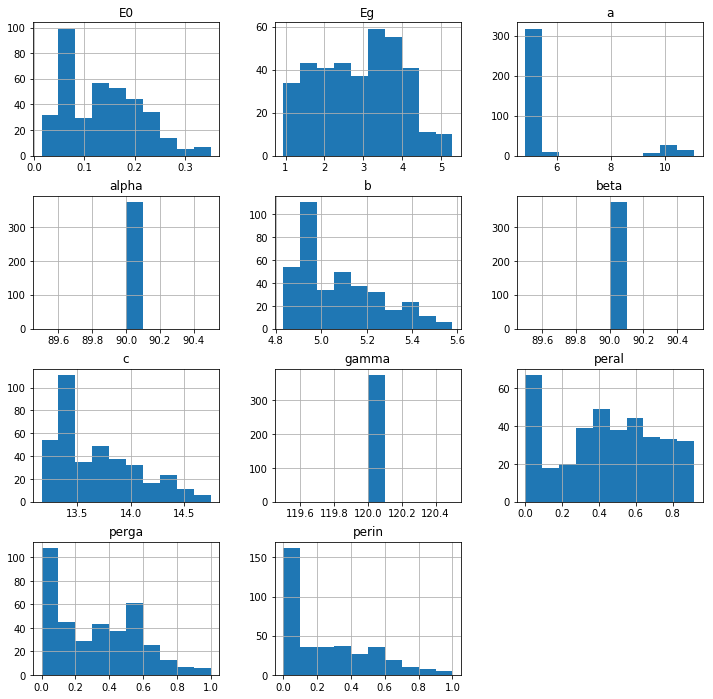

In [43]:
#plt.subplots(figsize=(15,12))
df_cpy[df_cpy['spacegroup']==167].hist(figsize=(12,12),column=crystal_vectors_withbandandenergy)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d2c94a2e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6d2c68e550>]], dtype=object)

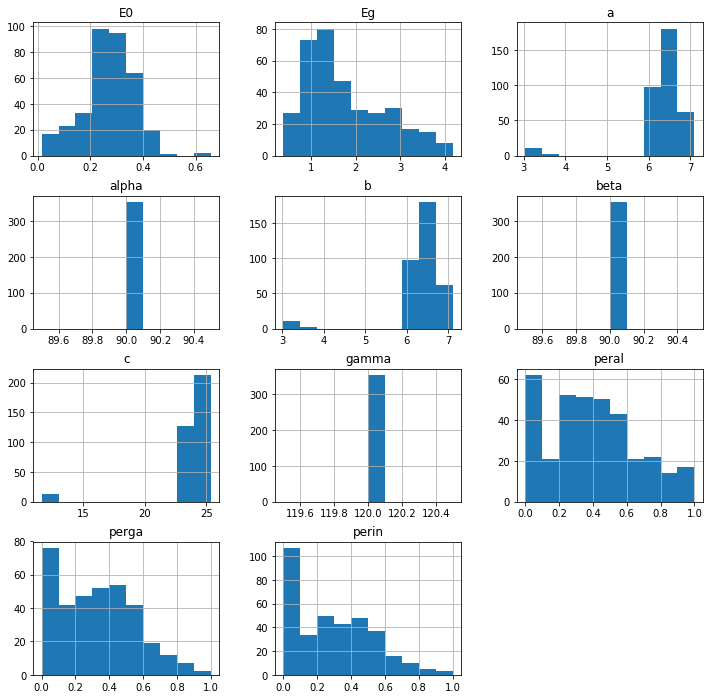

In [44]:
#plt.subplots(figsize=(15,12))
df_cpy[df_cpy['spacegroup']==194].hist(figsize=(12,12),column=crystal_vectors_withbandandenergy)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d2c50bf60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6d2c1de3c8>]], dtype=object)

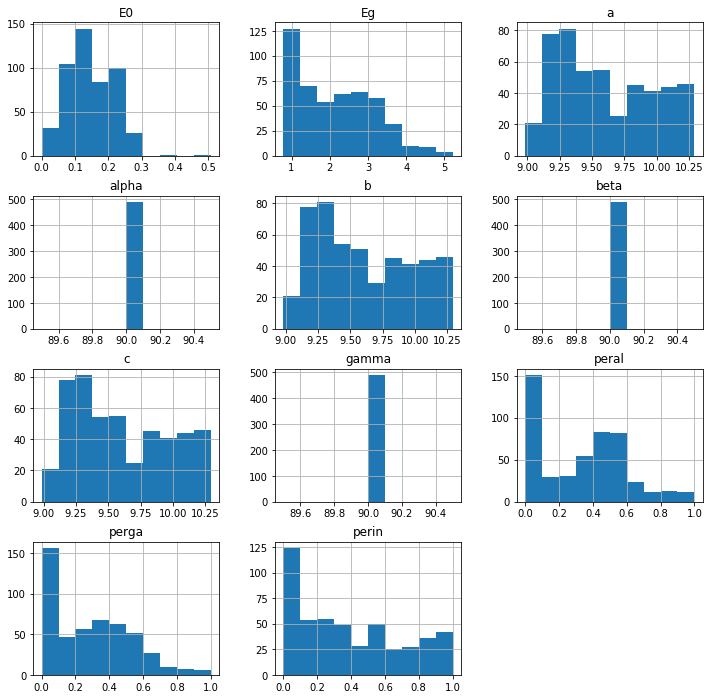

In [45]:
#plt.subplots(figsize=(15,12))
df_cpy[df_cpy['spacegroup']==206].hist(figsize=(12,12),column=crystal_vectors_withbandandenergy)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d2c09f278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6d27ca2208>]], dtype=object)

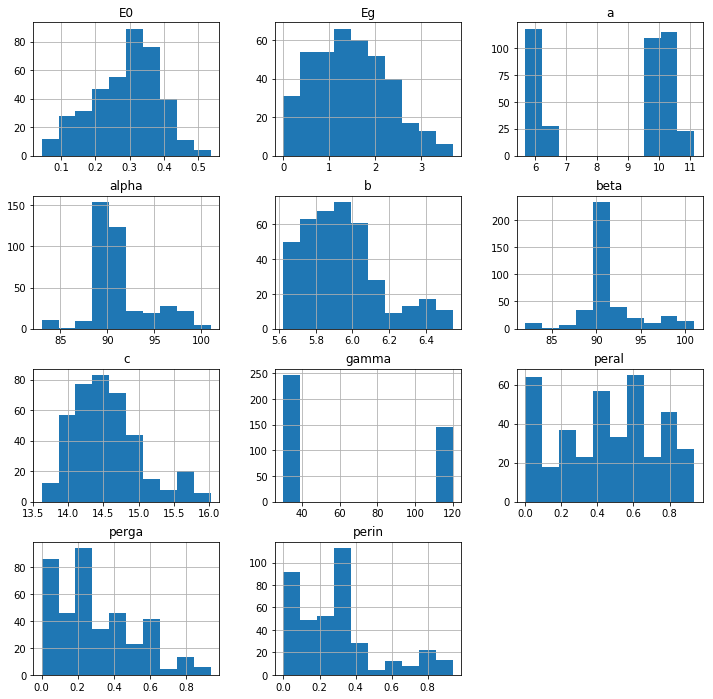

In [46]:
#plt.subplots(figsize=(15,12))
df_cpy[df_cpy['spacegroup']==227].hist(figsize=(12,12),column=crystal_vectors_withbandandenergy)


In [47]:
df_cpy.groupby(['spacegroup'])['Eg'].describe()

,count,mean,std,min,25%,50%,75%,max
spacegroup,,,,,,,,
12,358.0,1.938706,0.667863,0.7220,1.480750,1.85690,2.251075,4.4587
33,432.0,2.196816,0.961137,0.6522,1.366475,2.07890,2.971500,4.6795
167,374.0,2.896165,1.066193,0.9439,1.979825,2.99680,3.716150,5.2861
194,353.0,1.760744,0.881789,0.3717,1.096400,1.50850,2.369200,4.1785
206,490.0,2.157506,0.991159,0.7883,1.214950,2.06875,2.905275,5.2114
227,393.0,1.476654,0.802300,0.0001,0.860900,1.44360,2.035700,3.6851


(array([   7.,   27.,   73.,    0.,  123.,    0.,    0.,   14.,    0.,  356.]),
 array([ 10.,  17.,  24.,  31.,  38.,  45.,  52.,  59.,  66.,  73.,  80.]),
 <a list of 10 Patch objects>)

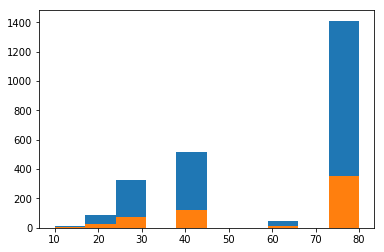

In [48]:
plt.hist(df_cpy['numatoms'])
plt.hist(df_topredictcpy['numatoms'])

So we see that the num of atoms in the training set and testing set take on same values. We can thus safely ignore the total num of atoms, because the formation energy and band gap doesnt vary with respect to varying number of total atoms as long as the composition and crystal structure remains constants. For eg, band gap of Al2O3 in space group 194 with 2 atoms of Al and 3 atoms of O would be the same as 4 atoms of Al and 6 atoms of O and so on. 

In [49]:
df_cpy.head()

,id,spacegroup,numatoms,peral,perga,perin,a,b,c,alpha,beta,gamma,E0,Eg
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0,90.0,90.0,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0,90.0,120.0,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,91.0,91.0,31.0,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,90.0,90.0,120.0,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,90.0,90.0,120.0,0.0505,1.3793


In [50]:
df_cpy = df_cpy.drop(['numatoms'],axis=1)
df_topredictcpy = df_topredictcpy.drop(['numatoms'],axis=1)

In [51]:
df_cpy = df_cpy.drop(['id'],axis=1)
df_topredictcpy = df_topredictcpy.drop(['id'],axis=1)

In [52]:
df_cpy.head()

,spacegroup,peral,perga,perin,a,b,c,alpha,beta,gamma,E0,Eg
0,33,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0,90.0,90.0,0.0680,3.4387
1,194,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0,90.0,120.0,0.2490,2.9210
2,227,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,91.0,91.0,31.0,0.1821,2.7438
3,167,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,90.0,90.0,120.0,0.2172,3.3492
4,194,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,90.0,90.0,120.0,0.0505,1.3793


In [53]:
df_topredictcpy.head()

,spacegroup,peral,perga,perin,a,b,c,alpha,beta,gamma
0,33,0.1875,0.4688,0.3438,10.5381,9.0141,9.6361,90.0,90.0,90.0
1,33,0.7500,0.2500,0.0000,9.8938,8.5014,9.1298,90.0,90.0,90.0
2,167,0.6667,0.1667,0.1667,4.9811,4.9808,13.4799,90.0,90.0,120.0
3,12,0.5625,0.4375,0.0000,24.3370,6.0091,5.7620,90.0,104.0,90.0
4,12,0.1875,0.5000,0.3125,24.6443,6.2906,6.1589,90.0,105.0,90.0


**Structure mapping **

The different values of spacegroup variable (12,33,167,194,206,227) are categorical values. So we have to convert them into one-hot encoding format. 

In [54]:
spacegroup_mapping = {12:1,33:2,167:3, 194:4, 206:5,227:6}

In [55]:
df_cpy['structure_mapped']=df_cpy['spacegroup'].map(spacegroup_mapping)
df_topredictcpy['structure_mapped']=df_topredictcpy['spacegroup'].map(spacegroup_mapping)

In [56]:
df_cpy = df_cpy.drop(['spacegroup'],axis=1)
df_topredictcpy = df_topredictcpy.drop(['spacegroup'],axis=1)

In [57]:
one_hot = pd.get_dummies(df_cpy['structure_mapped'],columns=['sg12','sg33','sg167','sg194','sg206','sg227'])
one_hot_topredict = pd.get_dummies(df_topredictcpy['structure_mapped'],columns=['sg12','sg33','sg167','sg194','sg206','sg227'])

In [58]:
df_cpy = df_cpy.join(one_hot)
df_topredictcpy = df_topredictcpy.join(one_hot_topredict)

In [59]:
df_cpy.rename(columns={1: 'sg12', 2: 'sg33',3: 'sg167',4: 'sg194',5: 'sg206',6: 'sg227'},inplace=True)
df_topredictcpy.rename(columns={1: 'sg12', 2: 'sg33',3: 'sg167',4: 'sg194',5: 'sg206',6: 'sg227'},inplace=True)

In [60]:
df_cpy = df_cpy.drop(['structure_mapped'],axis=1)
df_topredictcpy = df_topredictcpy.drop(['structure_mapped'],axis=1)

In [61]:
df_cpy.head()

,peral,perga,perin,a,b,c,alpha,beta,gamma,E0,Eg,sg12,sg33,sg167,sg194,sg206,sg227
0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0,90.0,90.0,0.0680,3.4387,0,1,0,0,0,0
1,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0,90.0,120.0,0.2490,2.9210,0,0,0,1,0,0
2,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,91.0,91.0,31.0,0.1821,2.7438,0,0,0,0,0,1
3,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,90.0,90.0,120.0,0.2172,3.3492,0,0,1,0,0,0
4,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,90.0,90.0,120.0,0.0505,1.3793,0,0,0,1,0,0


In [62]:
df_topredictcpy.head()

,peral,perga,perin,a,b,c,alpha,beta,gamma,sg12,sg33,sg167,sg194,sg206,sg227
0,0.1875,0.4688,0.3438,10.5381,9.0141,9.6361,90.0,90.0,90.0,0,1,0,0,0,0
1,0.7500,0.2500,0.0000,9.8938,8.5014,9.1298,90.0,90.0,90.0,0,1,0,0,0,0
2,0.6667,0.1667,0.1667,4.9811,4.9808,13.4799,90.0,90.0,120.0,0,0,1,0,0,0
3,0.5625,0.4375,0.0000,24.3370,6.0091,5.7620,90.0,104.0,90.0,1,0,0,0,0,0
4,0.1875,0.5000,0.3125,24.6443,6.2906,6.1589,90.0,105.0,90.0,1,0,0,0,0,0


**Feature Scaling**

Now we have manipulated the data and converted all inputs into the parameters we want to input in the ML model. However, the dataset remains a bit skewed wrt to the range of values the features take. For eg. a takes a max value of ~25, and gamma takes on 120 while the elemental compositions take on a maximum value of 1. This leads to a problem while the algorithms try to find the minimum using gradient descent. So we feature scale the values so that all features take on values from 0-1. But since features a, b,c are of the same type  and alpha,beta and gamma are of the same type, we need to maintain the relative ratios (ie a:b, alpha:beta etc). So, we are going to feature scale the lattice vectors with  a same scale and angles with a same scale.

In [63]:
length_max = max(max(df_cpy['a']),max(df_cpy['b']),max(df_cpy['c']))
angle_max=max(max(df_cpy['alpha']),max(df_cpy['beta']),max(df_cpy['gamma']))

In [64]:
angle_max

120.0

In [65]:
df_cpy['alpha_reduced'] = df_cpy['alpha']/(angle_max)
df_cpy['beta_reduced'] = df_cpy['beta']/(angle_max)
df_cpy['gamma_reduced'] = df_cpy['gamma']/(angle_max)
df_topredictcpy['alpha_reduced'] = df_topredictcpy['alpha']/(angle_max)
df_topredictcpy['beta_reduced'] = df_topredictcpy['beta']/(angle_max)
df_topredictcpy['gamma_reduced'] = df_topredictcpy['gamma']/(angle_max)
df_cpy['a_reduced'] = df_cpy['a']/(length_max)
df_cpy['b_reduced'] = df_cpy['b']/(length_max)
df_cpy['c_reduced'] = df_cpy['c']/(length_max)
df_topredictcpy['a_reduced'] = df_topredictcpy['a']/(length_max)
df_topredictcpy['b_reduced'] = df_topredictcpy['b']/(length_max)
df_topredictcpy['c_reduced'] = df_topredictcpy['c']/(length_max)                                                                           

In [66]:
df_cpy.head()

,peral,perga,perin,a,b,c,alpha,beta,gamma,E0,...,sg167,sg194,sg206,sg227,alpha_reduced,beta_reduced,gamma_reduced,a_reduced,b_reduced,c_reduced
0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0,90.0,90.0,0.0680,...,0,0,0,0,0.750000,0.750000,0.750000,0.392658,0.337383,0.362089
1,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0,90.0,120.0,0.2490,...,0,1,0,0,0.750000,0.750000,1.000000,0.243983,0.243975,0.932246
2,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,91.0,91.0,31.0,0.1821,...,0,0,0,1,0.758333,0.758333,0.258333,0.384716,0.223290,0.550896
3,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,90.0,90.0,120.0,0.2172,...,1,0,0,0,0.750000,0.750000,1.000000,0.197412,0.197404,0.533883
4,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,90.0,90.0,120.0,0.0505,...,0,1,0,0,0.750000,0.750000,1.000000,0.262819,0.262811,0.969830


In [67]:
df_cpy = df_cpy.drop(['alpha','beta','gamma'],axis=1)
df_topredictcpy = df_topredictcpy.drop(['alpha','beta','gamma'],axis=1)

In [68]:
df_cpy = df_cpy.drop(['a','b','c'],axis=1)
df_topredictcpy = df_topredictcpy.drop(['a','b','c'],axis=1)

Now all our features have values in the range 0 - 1. Now lets go ahead and look at the distributions of the features with the reduced dimensions for a random spacegroup.

In [69]:
crystal_vectors_withbandandenergy_reduced = ['a_reduced','b_reduced','c_reduced','alpha_reduced','beta_reduced','gamma_reduced','Eg','E0','perin','peral','perga']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d279dce80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6d27749860>]], dtype=object)

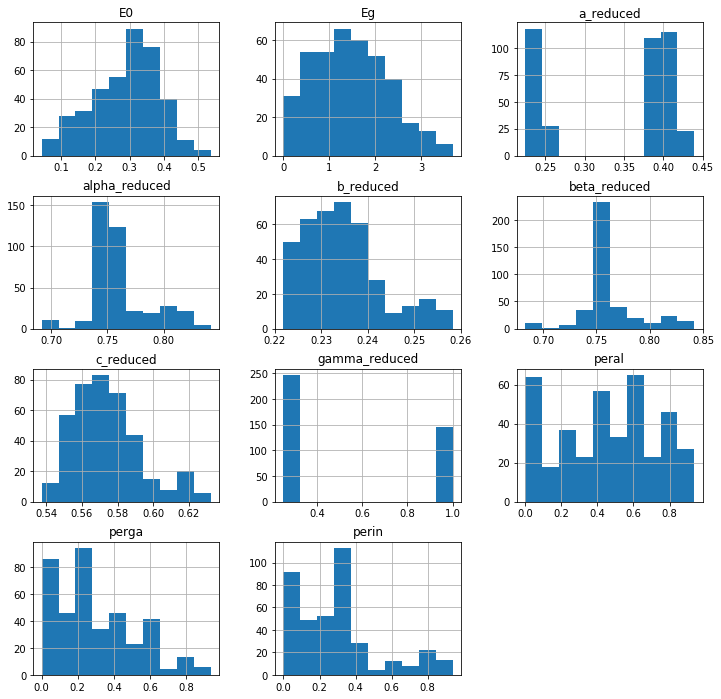

In [70]:
#plt.subplots(figsize=(15,12))
df_cpy[df_cpy['sg227']==1].hist(figsize=(12,12),column=crystal_vectors_withbandandenergy_reduced)


In [71]:
df_cpy.head()

,peral,perga,perin,E0,Eg,sg12,sg33,sg167,sg194,sg206,sg227,alpha_reduced,beta_reduced,gamma_reduced,a_reduced,b_reduced,c_reduced
0,0.6250,0.3750,0.000,0.0680,3.4387,0,1,0,0,0,0,0.750000,0.750000,0.750000,0.392658,0.337383,0.362089
1,0.6250,0.3750,0.000,0.2490,2.9210,0,0,0,1,0,0,0.750000,0.750000,1.000000,0.243983,0.243975,0.932246
2,0.8125,0.1875,0.000,0.1821,2.7438,0,0,0,0,0,1,0.758333,0.758333,0.258333,0.384716,0.223290,0.550896
3,0.7500,0.0000,0.250,0.2172,3.3492,0,0,1,0,0,0,0.750000,0.750000,1.000000,0.197412,0.197404,0.533883
4,0.0000,0.6250,0.375,0.0505,1.3793,0,0,0,1,0,0,0.750000,0.750000,1.000000,0.262819,0.262811,0.969830


In [72]:
df_topredictcpy.head()

,peral,perga,perin,sg12,sg33,sg167,sg194,sg206,sg227,alpha_reduced,beta_reduced,gamma_reduced,a_reduced,b_reduced,c_reduced
0,0.1875,0.4688,0.3438,0,1,0,0,0,0,0.75,0.750000,0.75,0.415770,0.355642,0.380182
1,0.7500,0.2500,0.0000,0,1,0,0,0,0,0.75,0.750000,0.75,0.390350,0.335414,0.360207
2,0.6667,0.1667,0.1667,0,0,1,0,0,0,0.75,0.750000,1.00,0.196524,0.196512,0.531835
3,0.5625,0.4375,0.0000,1,0,0,0,0,0,0.75,0.866667,0.75,0.960191,0.237083,0.227334
4,0.1875,0.5000,0.3125,1,0,0,0,0,0,0.75,0.875000,0.75,0.972315,0.248189,0.242993


In [73]:
band = df_cpy['Eg']
energy = df_cpy['E0']

In [74]:
df_cpy = df_cpy.drop(['Eg','E0'],axis=1)

In [75]:
df_cpy.head()

,peral,perga,perin,sg12,sg33,sg167,sg194,sg206,sg227,alpha_reduced,beta_reduced,gamma_reduced,a_reduced,b_reduced,c_reduced
0,0.6250,0.3750,0.000,0,1,0,0,0,0,0.750000,0.750000,0.750000,0.392658,0.337383,0.362089
1,0.6250,0.3750,0.000,0,0,0,1,0,0,0.750000,0.750000,1.000000,0.243983,0.243975,0.932246
2,0.8125,0.1875,0.000,0,0,0,0,0,1,0.758333,0.758333,0.258333,0.384716,0.223290,0.550896
3,0.7500,0.0000,0.250,0,0,1,0,0,0,0.750000,0.750000,1.000000,0.197412,0.197404,0.533883
4,0.0000,0.6250,0.375,0,0,0,1,0,0,0.750000,0.750000,1.000000,0.262819,0.262811,0.969830


**Running the ML algorithms:**
Now we have manipulated the data to feed into the algorithm. So we are going to split the dataset into training and testing sets. Since we have 2 target variables: formation enthalpy and band gap, we have to run algorithms for each target variable

In [76]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neural_network import  MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

X_train,X_test,Y_train,Y_test = train_test_split(df_cpy,band,test_size=0.2,random_state = 42)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [77]:
print (Y_test.shape)

(480,)


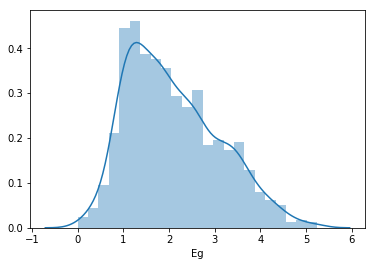

In [78]:
sns.distplot(Y_train)

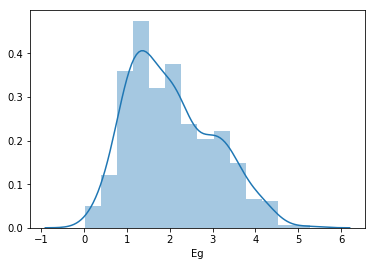

In [79]:
sns.distplot(Y_test)

We see that the training and testing target variable (band gap) have similar distributions. So the training and testing sets are good statistical samples of the overall sample

In [80]:
#Y_test = np.array(Y_test)

In [81]:
print (X_train.shape,X_test.shape)

(1920, 15) (480, 15)


In [82]:
clf_tree_band = DecisionTreeRegressor(random_state = 42, max_depth=15,min_samples_split=2)
#clf_gauss = GaussianNB()
clf_kernal_band = KernelRidge(alpha=1)
clf_linear_band = LinearRegression()
clf_svr_band = SVR()
clf_neural_band = MLPRegressor(hidden_layer_sizes=10, solver="sgd",early_stopping=True)
clf_neigh_band = KNeighborsRegressor(n_neighbors=10)
clf_random_band = RandomForestRegressor(n_estimators=200)

In [83]:
clf_tree_band.fit(X_train,Y_train)
#clf_gauss.fit(X_train,Y_train)
clf_kernal_band.fit(X_train,Y_train)
clf_linear_band.fit(X_train,Y_train)
clf_svr_band.fit(X_train,Y_train)
clf_neural_band.fit(X_train,Y_train)
clf_neigh_band.fit(X_train,Y_train)
clf_random_band.fit(X_train,Y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [84]:
pred_tree_band = clf_tree_band.predict(X_test)
pred_kernal_band = clf_kernal_band.predict(X_test)
pred_linear_band = clf_linear_band.predict(X_test)
pred_svr_band = clf_svr_band.predict(X_test)
pred_neural_band = clf_neural_band.predict(X_test)
pred_neigh_band = clf_neigh_band.predict(X_test)
pred_random_band = clf_random_band.predict(X_test)

In [85]:
#pred=  np.array(pred)
from sklearn.metrics import  mean_squared_error

In [86]:
#clf_tree.score(pred,Y_test)
print(1- mean_squared_error(Y_test,pred_tree_band))
print(1- mean_squared_error(Y_test,pred_kernal_band))
print(1- mean_squared_error(Y_test,pred_linear_band))
print(1- mean_squared_error(Y_test,pred_svr_band))
print(1- mean_squared_error(Y_test,pred_neural_band))
print (1- mean_squared_error(Y_test,pred_neigh_band))
print (1- mean_squared_error(Y_test,pred_random_band))

0.904538604148
0.891067651644
0.888457380217
0.930524356406
0.915096959072
0.922553278421
0.93583221726


We see that random forest algorithms gives us the best results, although the accuracy could have been better. One possible way to imporve accuracy can be to increase the number of features and number of datapoints

In [87]:
Y_test = np.array(Y_test)
from sklearn.metrics import mean_absolute_error

In [88]:
err_array=[];
for i in range(len(pred_random_band)):
    err = abs(pred_random_band[i]-Y_test[i])
    err_array.append(err)
max_error = max(err_array)   
print (np.mean(err_array))
print (max_error)  

    

0.147912652594
1.64898914844


Text(0.5,0,'Error in prediction (eV)')

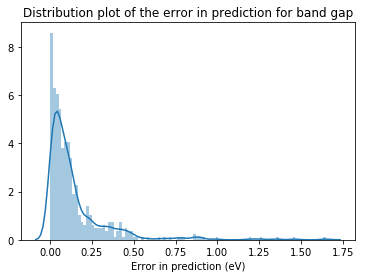

In [89]:
sns.distplot(err_array,bins=100)
plt.title("Distribution plot of the error in prediction for band gap")
plt.xlabel ("Error in prediction (eV)")

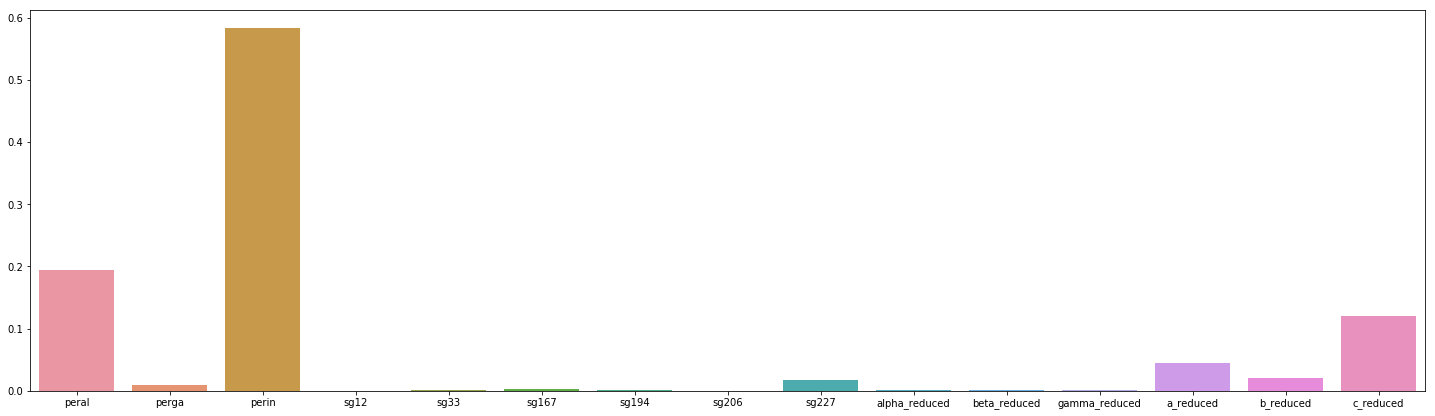

In [90]:
 plt.subplots(figsize=(25,7))
sns.barplot(df_cpy.columns,clf_random_band.feature_importances_)

In [91]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neural_network import  MLPRegressor
from sklearn.ensemble import RandomForestRegressor

X_train_enthalpy,X_test_enthalpy,Y_train_enthalpy,Y_test_enthalpy = train_test_split(df_cpy,energy,test_size=0.2,random_state = 42)

In [92]:
clf_tree_enthalpy = DecisionTreeRegressor(random_state = 42, max_depth=10,min_samples_split=2)
#clf_gauss = GaussianNB()
clf_kernal_enthalpy = KernelRidge(alpha=1)
clf_linear_enthalpy = LinearRegression()
clf_svr_enthalpy = SVR()
clf_neural_enthalpy = MLPRegressor(hidden_layer_sizes=10, solver="sgd",early_stopping=True)
clf_random_enthalpy = RandomForestRegressor(n_estimators=100)

In [93]:
clf_tree_enthalpy.fit(X_train_enthalpy,Y_train_enthalpy)
#clf_gauss.fit(X_train,Y_train)
clf_kernal_enthalpy.fit(X_train_enthalpy,Y_train_enthalpy)
clf_linear_enthalpy.fit(X_train_enthalpy,Y_train_enthalpy)
clf_svr_enthalpy.fit(X_train_enthalpy,Y_train_enthalpy)
clf_neural_enthalpy.fit(X_train_enthalpy,Y_train_enthalpy)
clf_random_enthalpy.fit(X_train_enthalpy,Y_train_enthalpy)

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [94]:
pred_tree_enthalpy = clf_tree_enthalpy.predict(X_test_enthalpy)
pred_kernal_enthalpy = clf_kernal_enthalpy.predict(X_test_enthalpy)
pred_linear_enthalpy = clf_linear_enthalpy.predict(X_test_enthalpy)
pred_svr_enthalpy = clf_svr_enthalpy.predict(X_test_enthalpy)
pred_neural_enthalpy = clf_neural_enthalpy.predict(X_test_enthalpy)
pred_random_enthalpy = clf_random_enthalpy.predict(X_test_enthalpy)

In [95]:
print(1- mean_squared_error(Y_test_enthalpy,pred_tree_enthalpy))
print(1- mean_squared_error(Y_test_enthalpy,pred_kernal_enthalpy))
print(1- mean_squared_error(Y_test_enthalpy,pred_linear_enthalpy))
print(1- mean_squared_error(Y_test_enthalpy,pred_svr_enthalpy))
#print(1- mean_squared_error(Y_test_enthalpy,pred_neigh_enthalpy))
print(1- mean_squared_error(Y_test_enthalpy,pred_neural_enthalpy))
print(1- mean_squared_error(Y_test_enthalpy,pred_random_enthalpy))

0.997214080211
0.994366146668
0.994411514583
0.995808252321
0.991587401129
0.997695246582


In [96]:
Y_test_enthalpy= np.array(Y_test_enthalpy)

In [97]:
err_array=[];
for i in range(len(pred_random_enthalpy)):
    err = abs(pred_random_enthalpy[i]-Y_test_enthalpy[i])
    err_array.append(err)
max_error = max(err_array)   
print (np.mean(err_array))
print (max_error)  

0.0289288294061
0.405478099206


Text(0.5,0,'Error in prediction (eV)')

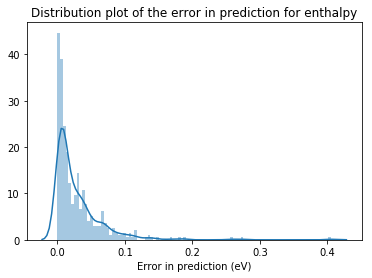

In [98]:
sns.distplot(err_array,bins=100)
plt.title("Distribution plot of the error in prediction for enthalpy")
plt.xlabel ("Error in prediction (eV)")

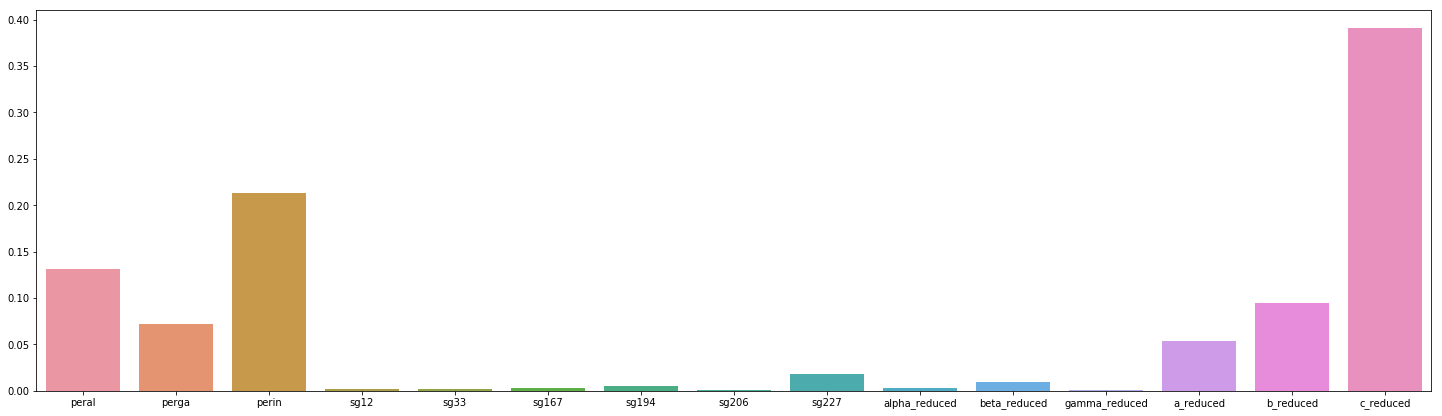

In [99]:
 plt.subplots(figsize=(25,7))
sns.barplot(df_cpy.columns,clf_random_enthalpy.feature_importances_)

So, based on the above fitting we see that indium compositions strongly affects both the formation enthalpies and band gap values (band gap more than formation enthalpies). Similarly, gallium and aluminium compositions affect the formation enthalpies but not so much for the band gap. However, what is surprising is that the lattice parameter "c" contributes very strongly to the formation enthalpy. This is likely a pure artifact of the dataset.

Text(0,0.5,'Predicted values for the test set for formation enthalpy (eV)')

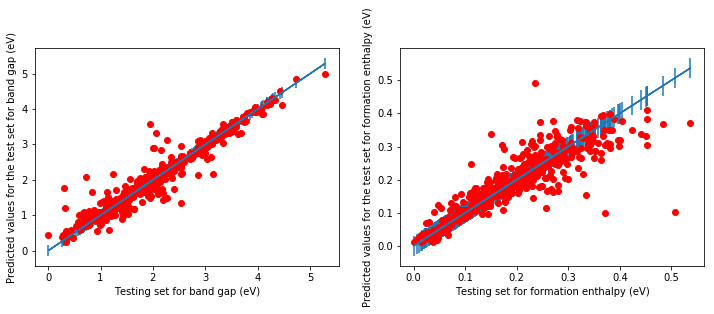

In [100]:
f,ax=plt.subplots(1,2,figsize=(12,4))
#ax[0].plot(df_cpy['perin'],df_cpy['E0'],'ro')
ax[0].plot(Y_test,pred_random_band,'ro')
#plt.plot(Y_test,Y_test,'k--')
ax[0].errorbar(Y_test,Y_test,xerr=0,yerr = 0.15)
ax[0].set_xlabel("Testing set for band gap (eV)")
ax[0].set_ylabel("Predicted values for the test set for band gap (eV)")
ax[1].plot(Y_test_enthalpy,pred_random_enthalpy,'ro')
#plt.plot(Y_test,Y_test,'k--')
ax[1].errorbar(Y_test_enthalpy,Y_test_enthalpy,xerr=0,yerr = 0.03)
ax[1].set_xlabel("Testing set for formation enthalpy (eV)")
ax[1].set_ylabel("Predicted values for the test set for formation enthalpy (eV)")

In [101]:
band_to_predict= clf_random_band.predict(df_topredictcpy)

In [102]:
enthalpy_to_predict = clf_random_enthalpy.predict(df_topredictcpy)

Text(0.5,0,'Band gap for the predicted set')

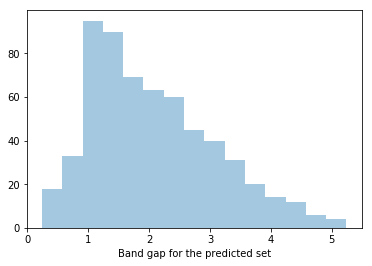

In [103]:
sns.distplot(band_to_predict,kde=False)
plt.xlabel("Band gap for the predicted set")

Text(0.5,0,'Formation enthalpies for the predicted set')

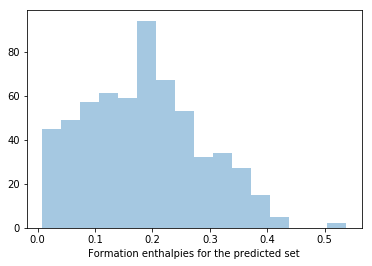

In [104]:
sns.distplot(enthalpy_to_predict,kde=False)
plt.xlabel("Formation enthalpies for the predicted set")